In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
import sys

HR:  [112. 112. 112. ... 106. 106. 106.]


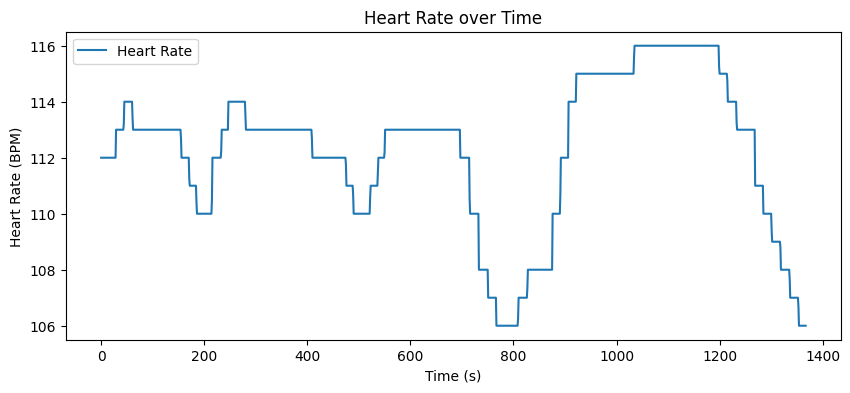

In [9]:
# dataset folder
root = '/content/drive/MyDrive/UBFC_DATASET/DATASET_2/'

# 폴더 목록 가져오기
dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
# 모든 폴더에 대해 반복

vid_folder = os.path.join(root, dir_name)

# load ground truth
gt_filename = os.path.join('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject4/', 'ground_truth.txt')
if os.path.exists(gt_filename):
  # 공백 또는 탭으로 구분된 파일로 가정
  wave, HR, wave_t = np.loadtxt(gt_filename)

print('HR: ', HR)

# 심박수 시각화
plt.figure(figsize=(10, 4))
plt.plot(HR, label='Heart Rate')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Heart Rate over Time')
plt.legend()
plt.show()

In [ ]:
def pulse_convert(current_path, tempPathNofile):
    f = open(current_path, 'r')
    lines = f.readlines()
    lines.pop(1)
    lines.pop(1)
    f.close()

    string_label = lines[0]
    bvp_label = string_label.split()
    for i, data in enumerate(bvp_label):
        bvp_label[i] = float(data)*100

    # save bvp_label as *.csv
    newDF = pd.DataFrame(bvp_label)
    newDF.to_csv(tempPathNofile, index=False, header=False)

base_path = "/content/drive/MyDrive/UBFC_DATASET/DATASET_2/"
output_base_path = '/content/drive/MyDrive/everglow/ubfc-rppg/'
subjects = [f"subject{i}" for i in range(1, 50)]

for subject in subjects:
    current_path = os.path.join(base_path, subject, "ground_truth.txt")
    output_path = os.path.join(output_base_path, subject)
    os.makedirs(output_path, exist_ok=True)
    tempPathNofile = os.path.join(output_path, "ground_truth_converted.csv")

    # 파일이 존재하는지 확인
    if os.path.exists(current_path):
        pulse_convert(current_path, tempPathNofile)
        print(f"Processed {subject}")
    else:
        print(f"File not found for {subject}")


In [5]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

## Make dataset

랜드마크를 통해 비디오를 자르고 3D-CNN의 64x64픽셀

In [10]:
sys.path.append('/content/drive/MyDrive/everglow')

import utils # utils 모듈이 현재 디렉토리 또는 PYTHONPATH 상에 있어야 함

# 알파벳 순서로 정렬해서 반환
def ls(x='.'):
    return sorted(os.listdir(x))

def join(*x):
    return os.path.join(*x)

def main(input_root, output_root):
    if not os.path.isdir(output_root):
        os.makedirs(output_root)

    sessions = ls(input_root)

    for session in sessions:
        video_path = join(input_root, session, 'vid.avi')
        output_path = join(output_root, f'{session}.npz')
        gt_path = join(input_root, session, f'ground_truth.txt')
        # 맥박 데이터 load
        # 맥박 신호(wave), 심박수(HR), 시간 정보(wave_t)
        wave, HR, wave_t = np.loadtxt(gt_path)
        lmrks = utils.mediapipe_landmark_video(video_path)
        output_video, successful = utils.make_video_array(video_path, lmrks) # 얼굴 랜드마크 탐지
        if successful:
            print('video shape: ', output_video.shape)
            # 얼굴 랜드마크 특징점
            print('lmrks shape: ', lmrks.shape)
            # 맥박 신호
            print('waves shape: ', wave.shape)
            # 심박수
            print('HR shape: ', HR.shape)
            print(output_path)
            #
            np.savez_compressed(output_path, video=output_video, wave=wave, hr=HR, video_path=video_path, fps=30)

# 직접 경로 설정
input_root = '/content/drive/MyDrive/UBFC_DATASET/DATASET_2' # UBFC-rPPG 데이터셋의 원본 경로
output_root = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz' # 전처리된 데이터셋이 저장될 경로

main(input_root, output_root)


video shape:  (1547, 64, 64, 3)
lmrks shape:  (1547, 68, 2)
waves shape:  (1547,)
HR shape:  (1547,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz
video shape:  (2024, 64, 64, 3)
lmrks shape:  (2024, 68, 2)
waves shape:  (2024,)
HR shape:  (2024,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz
video shape:  (2031, 64, 64, 3)
lmrks shape:  (2031, 68, 2)
waves shape:  (2031,)
HR shape:  (2031,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz
video shape:  (1989, 64, 64, 3)
lmrks shape:  (1989, 68, 2)
waves shape:  (1989,)
HR shape:  (1989,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz
video shape:  (2018, 64, 64, 3)
lmrks shape:  (2018, 68, 2)
waves shape:  (2018,)
HR shape:  (2018,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz
video shape:  (1993, 64, 64, 3)
lmrks shape:  (1993, 68, 2)
waves shape:  (1993,)
HR shape:  (1993,)
/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz
video shape:  (20

In [11]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)

keys = data.files
print("Keys in the npz file:", keys)

for key in keys:
    print(f"Shape of the data associated with key '{key}':", data[key].shape)

Keys in the npz file: ['video', 'wave', 'hr', 'video_path', 'fps']
Shape of the data associated with key 'video': (1547, 64, 64, 3)
Shape of the data associated with key 'wave': (1547,)
Shape of the data associated with key 'hr': (1547,)
Shape of the data associated with key 'video_path': ()
Shape of the data associated with key 'fps': ()


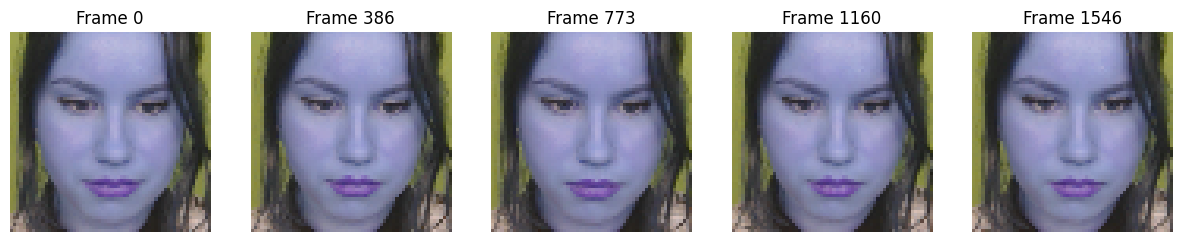

In [12]:
video = data['video']

num_frames, height, width, channels = video.shape

# 시각화할 프레임의 인덱스 선택
frame_indices = [0, num_frames // 4, num_frames // 2, 3 * num_frames // 4, num_frames - 1]

# 선택된 프레임 시각화
fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 5))
for ax, frame_idx in zip(axes, frame_indices):
    ax.imshow(video[frame_idx])
    ax.set_title(f'Frame {frame_idx}')
    ax.axis('off')
plt.show()

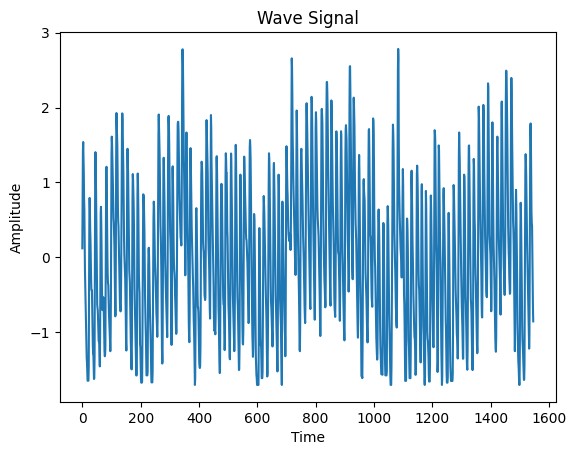

In [13]:
# 맥박 데이터 시각화
wave = data['wave']

plt.plot(wave)
plt.title('Wave Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

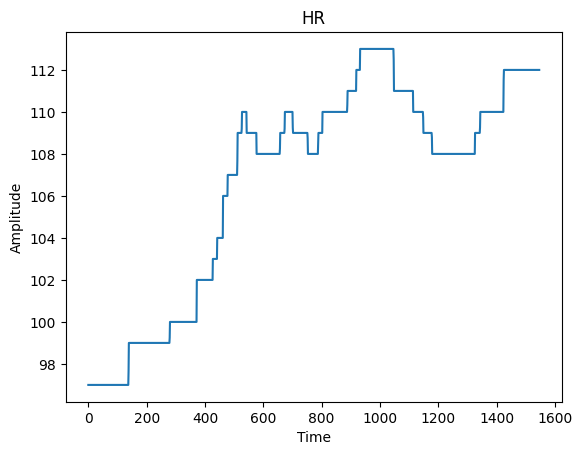

In [16]:
# 심박수 데이터 시각화
hr = data['hr']

plt.plot(hr)
plt.title('HR')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## Make metadata

In [14]:

def main(input_root, output_path):
    subjects = natsorted(os.listdir(input_root))
    ids = []
    paths = []
    for subject in subjects:
        # 'subject' 문자열 뒤의 숫자(ID)를 추출합니다.
        subject_id = int(''.join(filter(str.isdigit, subject)))
        print(subject, subject_id)
        subject_path = os.path.join(input_root, subject)
        subject_path = os.path.abspath(subject_path)
        paths.append(subject_path)
        ids.append(subject_id)

    d = {}
    d['id'] = ids
    d['path'] = paths

    df = pd.DataFrame(d)
    df.to_csv(output_path, index=False)
    print(df)

# 입력 및 출력 경로 직접 설정
input_root = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz'  # 여기에 실제 경로를 입력하세요.
output_path = '/content/drive/MyDrive/everglow/ubfc-rppg/metadata_hr_csv_path.csv'  # 여기에 실제 경로를 입력하세요.

main(input_root, output_path)


subject1.npz 1
subject3.npz 3
subject4.npz 4
subject5.npz 5
subject8.npz 8
subject9.npz 9
subject10.npz 10
subject11.npz 11
subject12.npz 12
subject13.npz 13
subject14.npz 14
subject15.npz 15
subject16.npz 16
subject17.npz 17
subject18.npz 18
subject20.npz 20
subject22.npz 22
subject23.npz 23
subject24.npz 24
subject25.npz 25
subject26.npz 26
subject27.npz 27
subject30.npz 30
subject31.npz 31
subject32.npz 32
subject33.npz 33
subject34.npz 34
subject35.npz 35
subject36.npz 36
subject37.npz 37
subject38.npz 38
subject39.npz 39
subject40.npz 40
subject41.npz 41
subject42.npz 42
subject43.npz 43
subject44.npz 44
subject45.npz 45
subject46.npz 46
subject47.npz 47
subject48.npz 48
subject49.npz 49
    id                                               path
0    1  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1    3  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2    4  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3    5  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4    8  

In [17]:
input_root = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz'  # 여기에 실제 경로를 입력하세요.
output_path = '/content/drive/MyDrive/everglow/ubfc-rppg/metadata_wave_csv_path.csv'  # 여기에 실제 경로를 입력하세요.

main(input_root, output_path)

subject1.npz 1
subject3.npz 3
subject4.npz 4
subject5.npz 5
subject8.npz 8
subject9.npz 9
subject10.npz 10
subject11.npz 11
subject12.npz 12
subject13.npz 13
subject14.npz 14
subject15.npz 15
subject16.npz 16
subject17.npz 17
subject18.npz 18
subject20.npz 20
subject22.npz 22
subject23.npz 23
subject24.npz 24
subject25.npz 25
subject26.npz 26
subject27.npz 27
subject30.npz 30
subject31.npz 31
subject32.npz 32
subject33.npz 33
subject34.npz 34
subject35.npz 35
subject36.npz 36
subject37.npz 37
subject38.npz 38
subject39.npz 39
subject40.npz 40
subject41.npz 41
subject42.npz 42
subject43.npz 43
subject44.npz 44
subject45.npz 45
subject46.npz 46
subject47.npz 47
subject48.npz 48
subject49.npz 49
    id                                               path
0    1  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1    3  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2    4  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3    5  /content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4    8  

In [15]:
df = pd.read_csv('/content/drive/MyDrive/everglow/ubfc-rppg/metadata_hr_csv_path.csv')
df

,id,path
0,1,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1,3,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2,4,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3,5,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4,8,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
5,9,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
6,10,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
7,11,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
8,12,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
9,13,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
